# 0 거리 계산을 위한 피처 맵  인덱스 고르기

## 0.1 정분류 테스트 데이터 피처 맵(평균 피처 맵 포함) 생성

In [ ]:
import numpy as np
import random

random_seed_id = 42
random_start = 1; random_end = 1000000

random.seed(random_seed_id + 4)

K = 10000
n = 36; m = 36

RFM_set = np.empty((1, n, m), dtype="int32")
RFM_mean = np.array([[0 for j in range(m)] for i in range(n)])

for k in range(K):
    RFM = np.array([[random.randint(random_start, random_end) for j in range(m)] for i in range(n)], dtype="int32")
    # np.append는 내장 append 함수와 다르게 차원이 같아야 append됨
    RFM_set = np.append(RFM_set, RFM.reshape(1, n, m), axis = 0)
    if k == 0:
        RFM_mean = RFM_mean + RFM
    else:
        RFM_mean = (RFM_mean*k + RFM) / (k+1)

RFM_set = np.delete(RFM_set, 0, axis=0)

## 0.2 훈련 데이터 평균 피처 맵(평균 피처 맵 포함) 생성

In [ ]:
# 랜덤하게 나오는 값 고정
random.seed(random_seed_id + 123)

TFM_set = np.empty((1, n, m), dtype="int32")
TFM_mean = np.array([[0 for j in range(m)] for i in range(n)]) # TFM_mean = TFM_mean

for k in range(K):
    TFM = np.array([[random.randint(random_start, random_end) for j in range(m)] for i in range(n)], dtype="int32")
    # np.append는 내장 append 함수와 다르게 차원이 같아야 append됨
    TFM_set = np.append(TFM_set, TFM.reshape(1, n, m), axis = 0)
    if k == 0:
        TFM_mean = TFM_mean + TFM
    else:
        TFM_mean = (TFM_mean*k + TFM) / (k+1)

TFM_set = np.delete(TFM_set, 0, axis=0)

## 0.3 n*m 크기의 임의의 오분류 테스트 데이터의 피처 맵 K개 생성
* random.seed(42)로 랜덤하게 나오는 것을 일정하게 만들어준다
* 피처 맵 계산 연습을 위한 K개의 n*m 사이즈의 테스트 데이터셋 생성

In [ ]:
import numpy as np
import random

random.seed(random_seed_id)

# shape이 (1, n, m)인 빈 np.array를 만듦
WFM_set = np.empty((1, n, m), dtype="int32")
WFM_mean = np.array([[0 for j in range(m)] for i in range(n)])

for k in range(K):
    WFM = np.array([[random.randint(random_start, random_end) for j in range(m)] for i in range(n)], dtype="int32")
    # np.append는 내장 append 함수와 다르게 차원이 같아야 append됨
    WFM_set = np.append(WFM_set, WFM.reshape(1, n, m), axis = 0)
    if k == 0:
        WFM_mean = WFM_mean + WFM
    else:
        WFM_mean = (WFM_mean*k + WFM) / (k+1)

WFM_set = np.delete(WFM_set, 0, axis=0)


## 0.4 피처 맵 인덱스 구하기

1. alpha 구하기

In [259]:
w_minus_r_max_alpha = [0,0]

alpha_min = int(np.array([RFM_mean.min(), TFM_mean.min(), WFM_mean.min()]).min())
alpha_max = int(np.array([RFM_mean.max(), TFM_mean.max(), WFM_mean.max()]).max())

for alpha in range(alpha_min, alpha_max+1):
    RAM = np.array(RFM_mean > alpha, dtype="int32")
    TAM = np.array(TFM_mean > alpha, dtype="int32")
    WAM = np.array(WFM_mean > alpha, dtype="int32")

    TAM_minus_RAM = TAM - RAM
    TAM_minus_WAM = TAM - WAM

    r = len(np.where(TAM_minus_RAM == 1)[0])
    w = len(np.where(TAM_minus_WAM == 1)[0])
    # w_minus_r_max_alpha의 인덱스 0이 w-r max이고, 인덱스 1이 alpha임
    if w-r > w_minus_r_max_alpha[0]:
        w_minus_r_max_alpha[0] = w-r
        w_minus_r_max_alpha[1] = alpha

alpha = w_minus_r_max_alpha[1]

2. 인덱스 구하기

In [260]:
RAM = RFM_mean > alpha
TAM = TFM_mean > alpha
WAM = WFM_mean > alpha

RandTAM = np.logical_and(RAM, TAM)

DAM = WAM.copy() # DAM = 거리 활성화 맵
np.place(DAM, RandTAM, 0)

nonzero_DAM = np.nonzero(DAM)
DAM_indexes = []
for i in range(len(DAM)):
    DAM_indexes.append((nonzero_DAM[0][i], nonzero_DAM[1][i]))

# 아래 주석을 해제하면 전체 인덱스로 거리 계산하고 그게 아니라면 알고리즘으로 고른 인덱스로 거리 계산함 
# DAM_indexes = [(i,j) for i in range(n) for j in range(m)]

# 1 각 인덱스의 거리에 대한 중간값, 평균, 표준편차 행렬을 구함
* 각 인덱스 (i,j)에서 오분류 테스트 데이터의 피처 맵과 베이스 피처 맵 사이의 유클리드 거리를 K개 나열할 때 이에 대한 중간값, 평균, 표준편차를 저장하는 행렬들 생성

**중간값**과 **평균**과 **표준편차**도 저장함

In [ ]:
# 각 인덱스 (i,j)에서 middle의 원소들은 그 인덱스 (i,j)에서 베이스 피처 맵와 오분류 테스트 데이터의 피처 맵의 거리를 K개 나열할 때

# 이 값들에 대한 중간값이어야 한다.
middle = np.empty((n,m), dtype="int32")
mean = np.empty((n,m), dtype="int32")
std = np.empty((n,m), dtype="int32")
min = np.empty((n,m), dtype="int32")
max = np.empty((n,m), dtype="int32")
Distance_arrays = np.empty((n,m)).tolist()

for i, j in DAM_indexes:
    Distance_array_i_j = np.empty((0), dtype="int32")
    for k in range(K):
        # 여기에서 '인덱스 간의 거리'를 어떻게 구할지 정하면 됨
        Distance_array_i_j = np.append(Distance_array_i_j, abs(TFM_mean[i][j] - WFM_set[k][i][j]))
    
    # 각 인덱스에서 유클리드 거리에 대한 중간값 평균 표준편차를 구하는 것임.
    Distance_arrays[i][j] = Distance_array_i_j
    middle[i][j] = sorted(Distance_array_i_j)[K // 2]
    mean[i][j] = Distance_array_i_j.mean()
    std[i][j] = Distance_array_i_j.std()
    min[i][j] = Distance_array_i_j.min()
    max[i][j] = Distance_array_i_j.max()

# Distance_arrays의 shape이 n*m*k인데 거리 계산을 더 빠르게 하기 위해서 k*n*m으로 자료구조를 바꿈
# TODO

# 2 베이스 피처 맵과 테스트 데이터의 피처맵 사이의 거리를 구함.



### 2.1 처음 착수보고서에 작성된 거리를 구하는 알고리즘은 다음과 같음

* 알고리즘으로 거리를 구함

In [ ]:
WFM_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WFM_k_FMD = 0

    for i, j in DAM_indexes:
        WFM_k_FMD += (Distance_arrays[i][j][k] / middle[i][j])**2
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)

* 알고리즘으로 구한 **거리에 대한 데이터들을 그래프**로 표현함

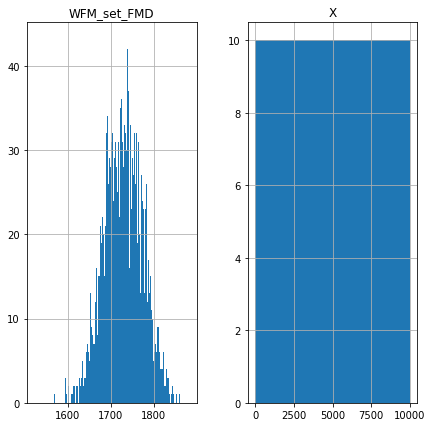

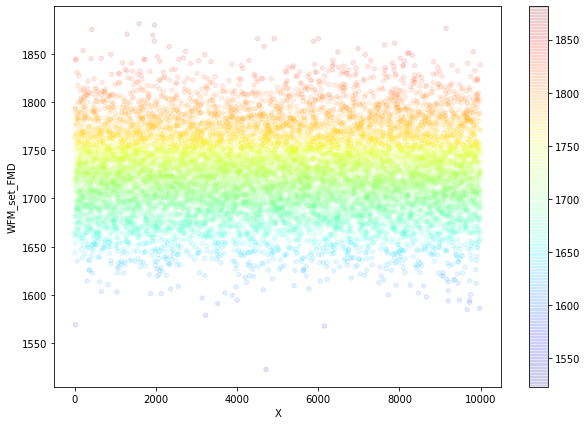

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

X = [i for i in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WFM_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

## 2.2 정규화를 시켜서 거리를 구함

* 정규화시키면 대략적으로 0보다 작은 값이 절반이고 0보다 큰 값이 절반 정도이다.  
* 따라서, exponential 함수를 쓰면 작은 값은 더 작아지고 큰 값은 더 커질 수 있다.  
* 그것에 대한 알고리즘을 짜려고 한다.

In [ ]:
from math import exp

WFM_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WFM_k_FMD = 0
    for i, j in DAM_indexes:
        WFM_k_FMD += exp(((Distance_arrays[i][j][k] - middle[i][j]) / std[i][j]))
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)

* 거리에 대한 그래프를 그린다.

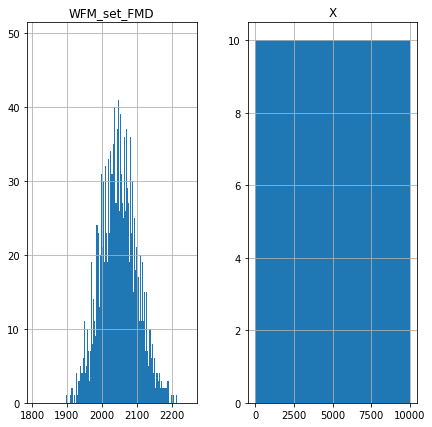

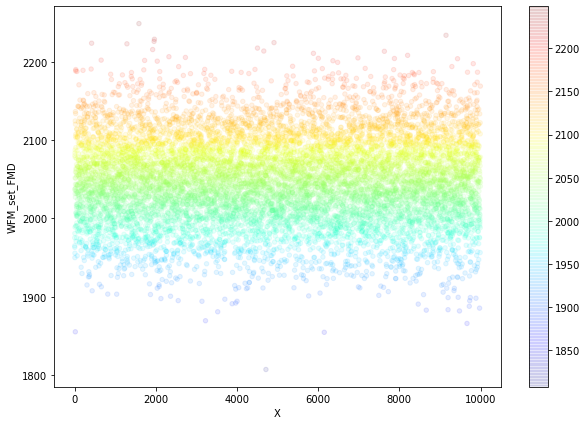

In [ ]:
import pandas as pd

X = [i for i in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WFM_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

### 2.2.1 정규화(normalization)에 대한 데이터 특징

In [ ]:
%matplotlib inline
import pandas as pd

normals = []

for i, j in DAM_indexes:
    normal_i_j = []
    for k in range(K):
        normal_i_j.append((abs(TFM_mean[i][j] - WFM_set[k][i][j]) - mean[i][j]) / std[i][j])
    normals.append(normal_i_j)

X = [i for i in range(K)]
normals.insert(0, X)

X_normals = np.array(normals).T

Columns_X_normals = ["X"]

for i, j in DAM_indexes:
    Columns_X_normals.append(f"normal_{i}_{j}")

df_X_normals = pd.DataFrame(X_normals, columns=Columns_X_normals)

# df_X_normals.hist(bins=100,figsize=(15,15))

for i, j in DAM_indexes:
    # df_X_normals.plot(kind="scatter", x="X", y="normal_"+f"{i}"+"_"+f"{j}", alpha=0.05)
    pass

# plt.show()


## 2.3 min-max과 shift를 이용해 거리를 구함

* min-max으로 데이터를 0\~1로 표준화를 시킨 후에 그 데이터의 middle보다 작거나 같은 값은 0\~1 사이의 값인데 제곱을 취하여 더 작은 값이 되도록 만든다.
* middle보다 큰 값은 middle이 1이 되도록 shift한 후 제곱을 취하여 더 큰 값이 되도록 한다.
* 거리의 maximum은 4 * K(테스트 케이스의 수)이다.

In [ ]:
WFM_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WFM_k_FMD = 0
    for i, j in DAM_indexes:
        min_max_distance = (Distance_arrays[i][j][k] - min[i][j]) / max[i][j]
        min_max_distance_of_middle = (middle[i][j]- min[i][j]) / max[i][j]
        if Distance_arrays[i][j][k] <= middle[i][j]:
            WFM_k_FMD += (min_max_distance)**2
        else:
            WFM_k_FMD += (min_max_distance + 1 - min_max_distance_of_middle)**2
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)



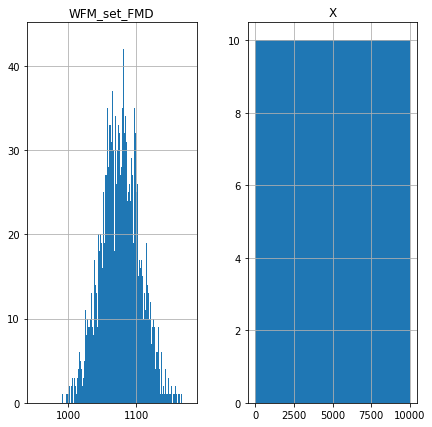

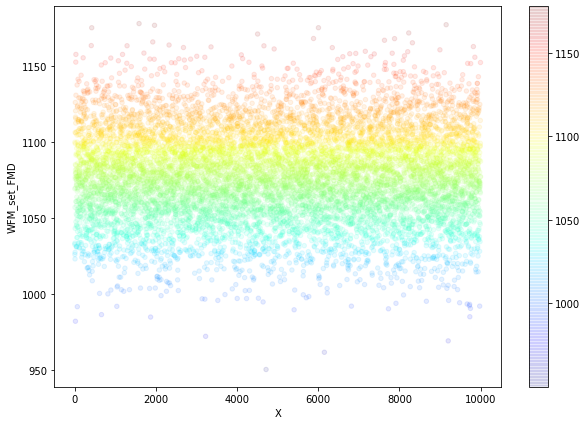

In [ ]:
import pandas as pd

X = [i for i in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WFM_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

# *연습

## *.1 각 인덱스에서 K개의 오분류 데이터에 대한 평균과 중간값의 관계를 살펴봄

In [ ]:
from matplotlib import pyplot as plt

head = 10; count = 0
# 각 인덱스에서 평균보다 낮은 값들의 수와 높은 값들의 수를 출력
for i, j in DAM_indexes:
    higher_than_mean = np.array((Distance_arrays[i][j] > mean[i][j]))
    higher_count = np.count_nonzero(higher_than_mean)
    print(f"(L: {K - higher_count}, H: {higher_count})")
    
    count += 1
    if count == (head-1):
        break


(L: 5024, H: 4976)
(L: 4982, H: 5018)
(L: 5004, H: 4996)
(L: 4983, H: 5017)
(L: 5010, H: 4990)
(L: 4975, H: 5025)
(L: 5019, H: 4981)
(L: 4983, H: 5017)
(L: 4997, H: 5003)


## *.2 행렬 크기에 상관없이 거리 계산을 적용할 수 있도록 만들기

이건 아마도 필요 없을 것 같다.

In [ ]:
# 오분류 테스트 데이터의 데이터 모양 구하기
data = WFM_set[0]
shape = data.shape
# 데이터 모양의 각 차원에 대한 index_max 구해서 N에 넣기
N = np.empty((0), dtype="int32")
print(N)
for dimension_index_max in shape:
    N = np.append(N, dimension_index_max)

N = np.array(N)

print(N)

I = [0 for i in range(len(N))]

middle_ = np.empty(N, dtype="int32")
mean_ = np.empty(N, dtype="int32")
std_ = np.empty(N, dtype="int32")
arrays_index_ = np.empty(N).tolist()

def set_matrices(I, D):
    if D == -1:
        for k in K:
            pass

        return

    for i in range(N[D]):
        I[D] = i
        set_matrices(I, D-1)

#

[]
[36 36]


## *.3 np.append에서 axis를 따라 더한다는 것에 대한 고찰

In [ ]:
N = 4
M = 5
L = 6

A = np.empty((N,M,L), dtype="int32")
B = np.empty((N,M,L))
D = np.empty((N,9,L))

for n in range(N):
    for m in range(M):
        for l in range(L):
            A[n][m][l] = (n+1)*100 + (m+1)*10 + (l+1) + 10000000
            B[n][m][l] = ((n+1)*100 + (m+1)*10 + (l+1))*1000 + 20000000

# print(A)
# print(B)
# C0 = np.append(A, B, axis=0)
# C1 = np.append(A, B, axis=1)
# C2 = np.append(A, B, axis=2)
# print("----------------------------------C0----------------------------------")
# print(C0)
# print("----------------------------------C1----------------------------------")
# print(C1)
# print("----------------------------------C2----------------------------------")
# print(C2)

E = np.append(A, D, axis=1)


## *.4 삼차원 데이터 그리기

matploblib 모듈에서 그래프 그리는 것에 대한 메소드를 다양하게 알아둘 필요가 있다.

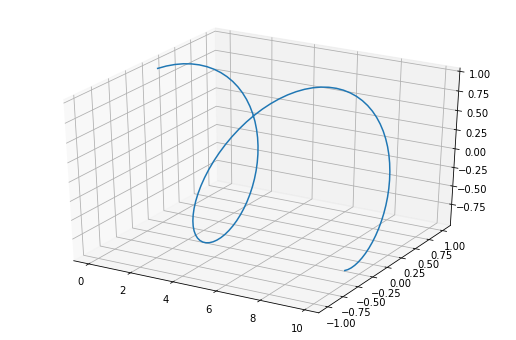

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, 10, 0.1)
y = np.sin(x)
z = np.cos(x)
ax.plot(x, y, z)